<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip3 install

In [1]:
!pip3 install scikit-image

# import

In [2]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

# Load kitti dataset

In [3]:
if "2011_09_26_drive_0020_sync.zip" not in os.listdir():
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
  !unzip  2011_09_26_drive_0020_sync.zip >/dev/null

dataset_dir = "./2011_09_26/2011_09_26_drive_0020_sync/image_02"
imgs_dir = os.path.join(dataset_dir, "data")
timestamps_file_path = os.path.join(dataset_dir, "timestamps.txt")

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
kitti_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

--2022-01-02 22:43:22--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.79
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367093728 (350M) [application/zip]
Saving to: ‘2011_09_26_drive_0020_sync.zip’

2011_09_26_drive_00 100%[===================>] 350.09M  29.4MB/s    in 13s     

2022-01-02 22:43:36 (26.5 MB/s) - ‘2011_09_26_drive_0020_sync.zip’ saved [367093728/367093728]



In [4]:
kitti_cam_calib = np.array([[7.215377e+02,0.000000e+00,6.095593e+02],
                            [0.000000e+00,7.215377e+02,1.728540e+02],
                            [0.000000e+00,0.000000e+00,1.000000e+00]])

# Disp utils

In [5]:
def disp(img_tn1, kps_tn1, kps_t):
  disp_img = img_tn1.copy()
  for kp_tn1, kp_t in zip(kps_tn1, kps_t):
    start_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 2, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, end_point, (0, 0, 255), 1)
  cv2_imshow(disp_img)

# Essential matrix utils

In [48]:
def triangulate(x_tn1, x_t, R, t):
  """
  Args:
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_tn1 of point to triangulate.
    x_t: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_t of point to triangulate.
    R: numpy array of shape (3,3) representing rotation of camera frame
      at time t wrt camera frame at time tn1.
    t: numpy array of shape (3,) representing baseline vector between 
    camera frame at time t and camera frame at time tn1.
  """
  A = np.array([
    [np.dot(x_tn1, x_tn1), -np.dot(R @ x_t, x_tn1)],
    [np.dot(x_tn1, R @ x_t), -np.dot(R @ x_t, R @ x_t)]
  ])
  b = np.array([np.dot(t, x_tn1) ,np.dot(t, R @ x_t)])
  alpha, beta = np.linalg.inv(A) @ b
  p_tn1 = alpha * x_tn1
  p_t = t + (beta * (R @ x_t))
  return (p_tn1 + p_t)/2

def essential_to_Rt(E, x_tn1, x_t):
  """
  Args:
    E: numpy array of shape (3,3) representing Essential matrix.
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_tn1.
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_t corresponding to x_tn1.
  """
  u,s,vt = np.linalg.svd(E)
  w = np.array([[0,-1,0],
                [1,0,0],
                [0,0,1]])
  R1 = u @ w.T @ vt
  if np.linalg.det(R1) < 0:
    R1 = -R1
  R2 = u @ w @ vt
  if np.linalg.det(R2) < 0:
    R2 = -R2

  t1 = u @ w @ np.diag(s) @ u.T
  t1 = np.array([t1[2,1], t1[0,2], t1[1,0]])
  t2 = -t1

  # Resolve ambiguities by triangulation
  p11_tn1 = triangulate(x_tn1, x_t, R1, t1)
  p11_t = R1.T @ (p11_tn1 - t1)
  if p11_tn1[2] > 0 and p11_t[2] > 0:
    return R1, t1

  p12_tn1 = triangulate(x_tn1, x_t, R1, t2)
  p12_t = R1.T @ (p12_tn1 - t2)
  if p12_tn1[2] > 0 and p12_t[2] > 0:
    return R1, t2
  
  p21_tn1 = triangulate(x_tn1, x_t, R2, t1)
  p21_t = R2.T @ (p21_tn1 - t1)
  if p21_tn1[2] > 0 and p21_t[2] > 0:
    return R2, t1

  p22_tn1 = triangulate(x_tn1, x_t, R2, t2)
  p22_t = R2.T @ (p22_tn1 - t2)
  if p22_tn1[2] > 0 and p22_t[2] > 0:
    return R2, t2
  
  raise Exception('Failed to resolve ambiguities!!')

In [49]:
class EssentialMatrixTransform():
  def __init__(self):
    # param contains essential matrix
    self.params = np.eye(3)

  def estimate(self, kps_tn1, kps_t):
    """
    Args:
      kps_tn1: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_tn1
      kps_t: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_t
    """
    # Setup constraint matrix
    A = np.column_stack((
      kps_tn1[:,0] * kps_t[:,0],
      kps_tn1[:,0] * kps_t[:,1],
      kps_tn1[:,0] * kps_t[:,2],
      kps_tn1[:,1] * kps_t[:,0],
      kps_tn1[:,1] * kps_t[:,1],
      kps_tn1[:,1] * kps_t[:,2],
      kps_tn1[:,2] * kps_t[:,0],
      kps_tn1[:,2] * kps_t[:,1],
      kps_tn1[:,2] * kps_t[:,2]
    ))

    # Solve for nullsapce of the constraint matrix
    u, s, vt = np.linalg.svd(A)
    E = vt[-1,:].reshape(3,3)

    # Enforcing Constraints:
    # 1. First and Second singular values should be equal
    # 2. Third singular value should be zero
    u, s, vt = np.linalg.svd(E)
    s[0] = s[1] = (s[0] + s[1])/2
    s[2] = 0
    self.params = u @ np.diag(s) @ vt

    return True

  def residuals(self, kps_tn1, kps_t):
    """
    Args:
      kps_tn1: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_tn1
      kps_t: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_t
    """
    e_tn1 = kps_t @ self.params.T  # Epipilar line on tn1 image
    e_t = kps_tn1 @ self.params  # Epipilar line on t image
    
    residue = (kps_tn1 * e_tn1).sum(axis = 1) # Residue from coplanarity constraint

    return np.abs(residue) / np.sqrt(e_tn1[:,0]**2 + e_tn1[:,1]**2
                                     + e_t[:,0]**2 + e_t[:,1]**2)

## Test

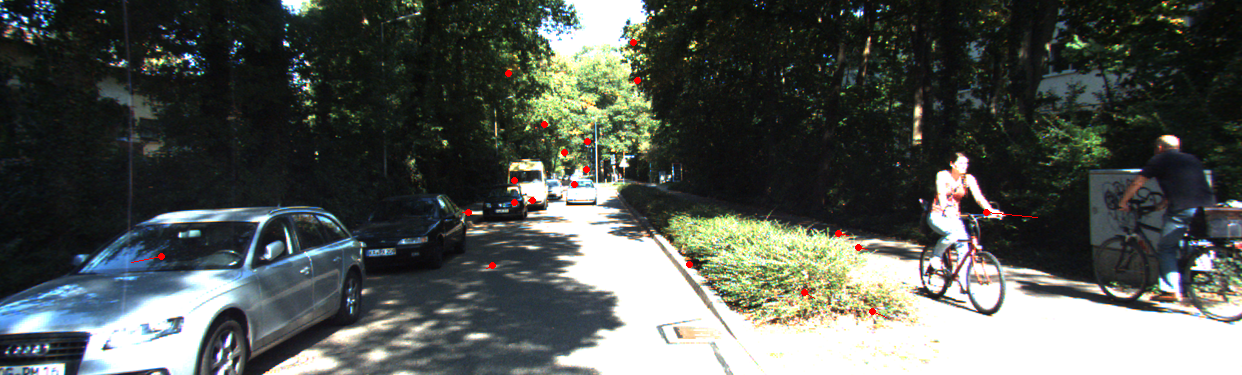

Essential Matrix: [[-0.00116678 -0.70698964 -0.01151313]
 [ 0.70698366 -0.00119731  0.00657523]
 [ 0.0110257  -0.00492258  0.00002276]]
Residuals for corresponding points:
[0.00060829 0.00041023 0.00025495 0.00123577 0.00105331 0.00057211
 0.0006894  0.00032432 0.00140733 0.0004235  0.00054837 0.00059094
 0.00032794 0.00032879 0.00015521 0.00061536 0.00075526 0.00015639
 0.00000194 0.00067527]
Residuals for random points:
[0.15842405 0.0922962  0.07382411 0.12052348 0.0006927  0.03488093
 0.04106192 0.15341657 0.00385255 0.00201525 0.06359249 0.08783428
 0.09043945 0.14531199 0.03245864 0.0786764  0.03076603 0.01069392
 0.00000194 0.00067527]


In [50]:
img_tn1 = kitti_imgs[0]
img_t = kitti_imgs[1]

# Ground truth corresponding Keypoints in img_tn1 and img_t
kps_tn1 = np.array([[838,233],[508,73],[514,180],[468,212],[587,141],[492,265],[986,212],[633, 42],[872,311],[544,124],
                    [804,292],[858,247],[689,264],[161,256],[574,184],[637,80],[532,200],[514,202],[564,152],[586,169]])

kps_t = np.array([[ 848,235],[506,72],[512,180],[462,212],[587,141],[486,268],[1037,217],[632,39],[886,317],[542,124],
                  [814,298],[867,249],[690,267],[131,262],[572,184],[636,79],[528,200],[512,202],[564,152],[585,169]])
kps_tn1_ = np.column_stack((kps_tn1, np.ones(len(kps_tn1)))) @ np.linalg.inv(kitti_cam_calib).T
kps_t_ = np.column_stack((kps_t, np.ones(len(kps_t)))) @ np.linalg.inv(kitti_cam_calib).T

disp(img_tn1, kps_tn1, kps_t)

E = EssentialMatrixTransform()
E.estimate(kps_tn1_, kps_t_)

print(f"Essential Matrix: {E.params}")

print("Residuals for corresponding points:")
print(E.residuals(kps_tn1_, kps_t_))

print("Residuals for random points:")
permutation = np.random.choice(range(20), replace=False, size=20)
print(E.residuals(kps_tn1_, kps_t_[permutation]))

# Features utils

In [9]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=5000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des


def match_features(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf_matcher.match(des_tn1, des_t)
  return np.array([[match.queryIdx, match.trainIdx] for match in matches])

def match_features2(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des_tn1, des_t, k=2)

  idx_tn1, idx_t = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance <= 1 * m2.distance:
      if m1.distance < 32:
        if m1.trainIdx not in idx_t:
          idx_tn1.append(m1.queryIdx)
          idx_t.append(m1.trainIdx)

  assert len(idx_tn1) >= 8, f"#matches: {len(idx_tn1)}" 
  return np.array([idx_tn1, idx_t]).T

# Main

#kps_tn1: 4933 #kps_t: 4943
Before RANSAC
#matches: 1805


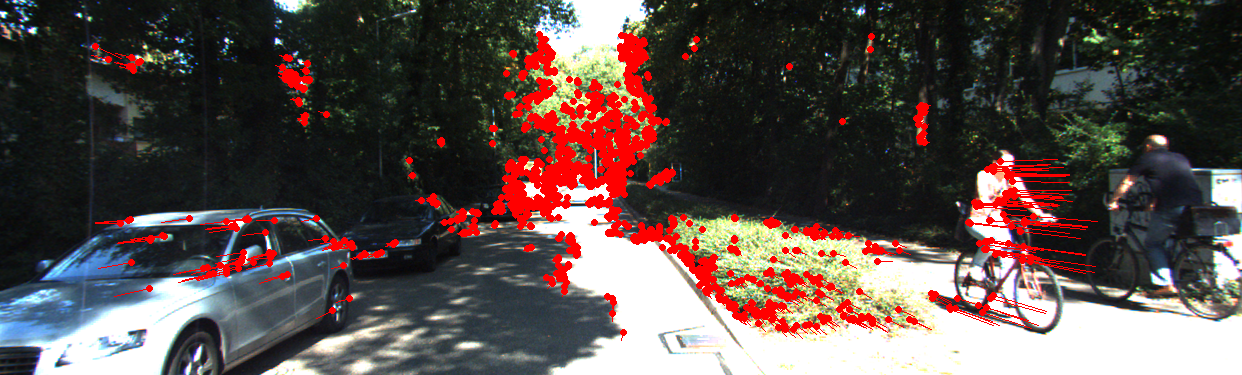

After RANSAC
#matches: 1283


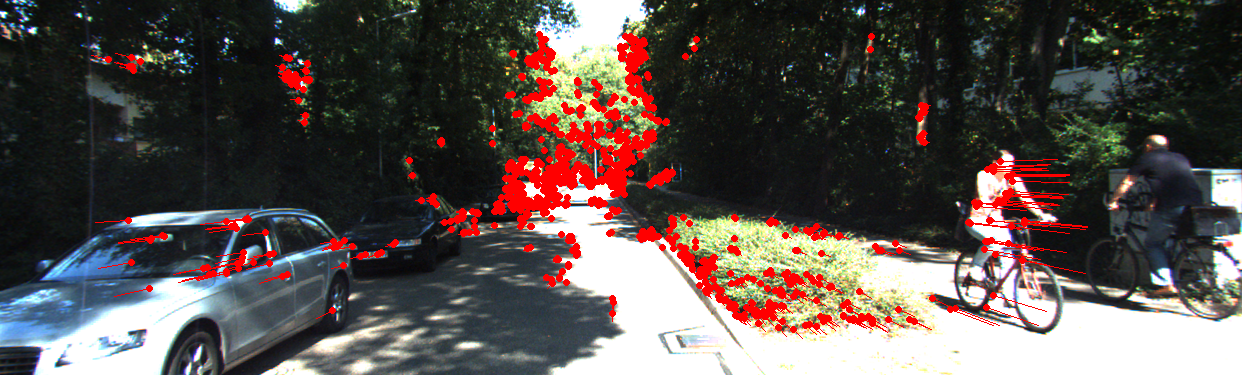

[[ 0.9999965   0.00131344  0.00229542]
 [-0.00131334  0.99999914 -0.00004247]
 [-0.00229548  0.00003946  0.99999736]]
[-0.02096581  0.00628787  0.70676774]


In [51]:
img_tn2 = kitti_imgs[0]
img_tn1 = kitti_imgs[1]
img_t = kitti_imgs[2]

kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_tn1: {len(kps_tn1)} #kps_t: {len(kps_t)}")

# From Image coordinate to Normalized homogeneous coordinate.
kps_tn1_ = np.column_stack((kps_tn1, np.ones(len(kps_tn1)))) @ np.linalg.inv(kitti_cam_calib).T
kps_t_ = np.column_stack((kps_t, np.ones(len(kps_t)))) @ np.linalg.inv(kitti_cam_calib).T

print("Before RANSAC")
matches = match_features2(des_tn1, des_t)
print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])

print("After RANSAC")
E, inliers = ransac(
  (kps_tn1_[matches[:,0]], kps_t_[matches[:,1]]),
  EssentialMatrixTransform,
  min_samples=8,
  residual_threshold=1e-3,
  max_trials=100
)
matches = matches[inliers]

print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])

np.set_printoptions(suppress=True)
R, t = essential_to_Rt(E.params, kps_tn1_[matches[0,0]], kps_t_[matches[0,1]])
print(R)
print(t)